In [ ]:
import tensorflow as tf
from google.colab import drive
import os


device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print(" DANGER: You are currently running on CPU!")
    print("Go to 'Runtime' -> 'Change runtime type' -> Select 'T4 GPU' -> Save.")
else:
    print(f"SUCCESS: Connected to {device_name} (T4 GPU)")
    print("Training will be fast.")


drive.mount('/content/drive')


DRIVE_SOURCE_PATH = '/content/drive/MyDrive/data'

if os.path.exists(DRIVE_SOURCE_PATH):
    print(f"✅ Found dataset folder at: {DRIVE_SOURCE_PATH}")
else:
    print(f"❌ ERROR: Could not find '{DRIVE_SOURCE_PATH}'")
    print("Please check if you created the shortcut correctly in Google Drive.")

✅ SUCCESS: Connected to /device:GPU:0 (T4 GPU)
Training will be fast.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Found dataset folder at: /content/drive/MyDrive/data


In [ ]:
import shutil
from PIL import Image
import os
import concurrent.futures
from tqdm import tqdm  

DRIVE_SOURCE_PATH = '/content/drive/MyDrive/data'
LOCAL_TEMP_PATH = '/content/temp_attendance_data'


print("Step 1: Copying files... (This depends on Google Drive speed, please wait)")
if os.path.exists(LOCAL_TEMP_PATH):
    shutil.rmtree(LOCAL_TEMP_PATH)

try:
    shutil.copytree(DRIVE_SOURCE_PATH, LOCAL_TEMP_PATH)
    print(" Copy complete.")
except Exception as e:
    print(f"Error during copy: {e}")


print("Step 2: Scanning for corrupt files using Multithreading...")

def check_image(file_path):
    """Helper function to check a single image"""
    try:
        with Image.open(file_path) as img:
            img.verify() 
        return None 
    except (IOError, SyntaxError, Image.UnidentifiedImageError):
        return file_path 


all_files = []
for root, dirs, files in os.walk(LOCAL_TEMP_PATH):
    for file in files:
        all_files.append(os.path.join(root, file))

print(f"Inspecting {len(all_files)} images...")

bad_files = []

with concurrent.futures.ThreadPoolExecutor() as executor:
    
    results = list(tqdm(executor.map(check_image, all_files), total=len(all_files)))


bad_files = [f for f in results if f is not None]


if bad_files:
    print(f"\n Found {len(bad_files)} corrupt files. Deleting...")
    for f in bad_files:
        try:
            os.remove(f)
        except:
            pass
    print(" cleanup done.")
else:
    print("\n No corrupt files found.")

print(f"\nREADY. You can now run the Training Cell.")

Step 1: Copying files... (This depends on Google Drive speed, please wait)
✅ Copy complete.
Step 2: Scanning for corrupt files using Multithreading...
Inspecting 1529 images...


100%|██████████| 1529/1529 [00:01<00:00, 1482.37it/s]


❌ Found 159 corrupt files. Deleting...
🗑️ cleanup done.

READY. You can now run the Training Cell.


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# AlexNet standard size
IMAGE_SIZE = (227, 227)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

print("Loading Training Data...")
train_generator = train_datagen.flow_from_directory(
    LOCAL_TEMP_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

print("Loading Validation Data...")
validation_generator = train_datagen.flow_from_directory(
    LOCAL_TEMP_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

class_names = list(train_generator.class_indices.keys())
print(f"Classes: {len(class_names)}")

Loading Training Data...
Found 1101 images belonging to 85 classes.
Loading Validation Data...
Found 261 images belonging to 85 classes.
Classes: 85


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization

model = Sequential([
    # Layer 1
    Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(227, 227, 3)),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    BatchNormalization(),

    # Layer 2
    Conv2D(256, (5, 5), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    BatchNormalization(),

    # Layer 3
    Conv2D(384, (3, 3), padding='same', activation='relu'),

    # Layer 4
    Conv2D(384, (3, 3), padding='same', activation='relu'),

    # Layer 5
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    BatchNormalization(),

    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])


model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print("Model Built.")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✅ Model Built.


In [ ]:
print("Starting Training...")
print("Look at the progress bar below to see every epoch.")

history = model.fit(
    train_generator,
    epochs=20, 
    validation_data=validation_generator,
    verbose=1 
)

print(" Training Finished.")

Starting Training...
Look at the progress bar below to see every epoch.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 126s 3s/step - accuracy: 0.0187 - loss: 7.8688 - val_accuracy: 0.0153 - val_loss: 39.1530
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 94s 3s/step - accuracy: 0.1047 - loss: 3.9763 - val_accuracy: 0.0192 - val_loss: 9.8933
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step - accuracy: 0.1189 - loss: 3.7394 - val_accuracy: 0.0460 - val_loss: 4.8553
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step - accuracy: 0.1461 - loss: 3.4955 - val_accuracy: 0.0843 - val_loss: 5.2831
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.1973 - loss: 3.3371 - val_accuracy: 0.0307 - val_loss: 7.7366
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.2101 - loss: 3.3414 - val_accuracy: 0.1034 - val_loss: 5.7019
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 94s 3s/step - accuracy: 0.2898 - loss: 2.9507 - val_accuracy: 0.0421 - val_loss: 8.4196
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 94s 3s/step - accuracy: 0.3418 - loss: 2.5719 - val_accuracy: 0.1111 - val_los

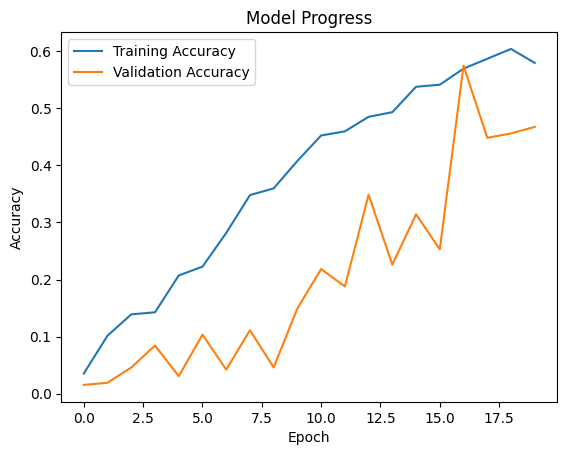

In [6]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Progress')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Asking model to identify students...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


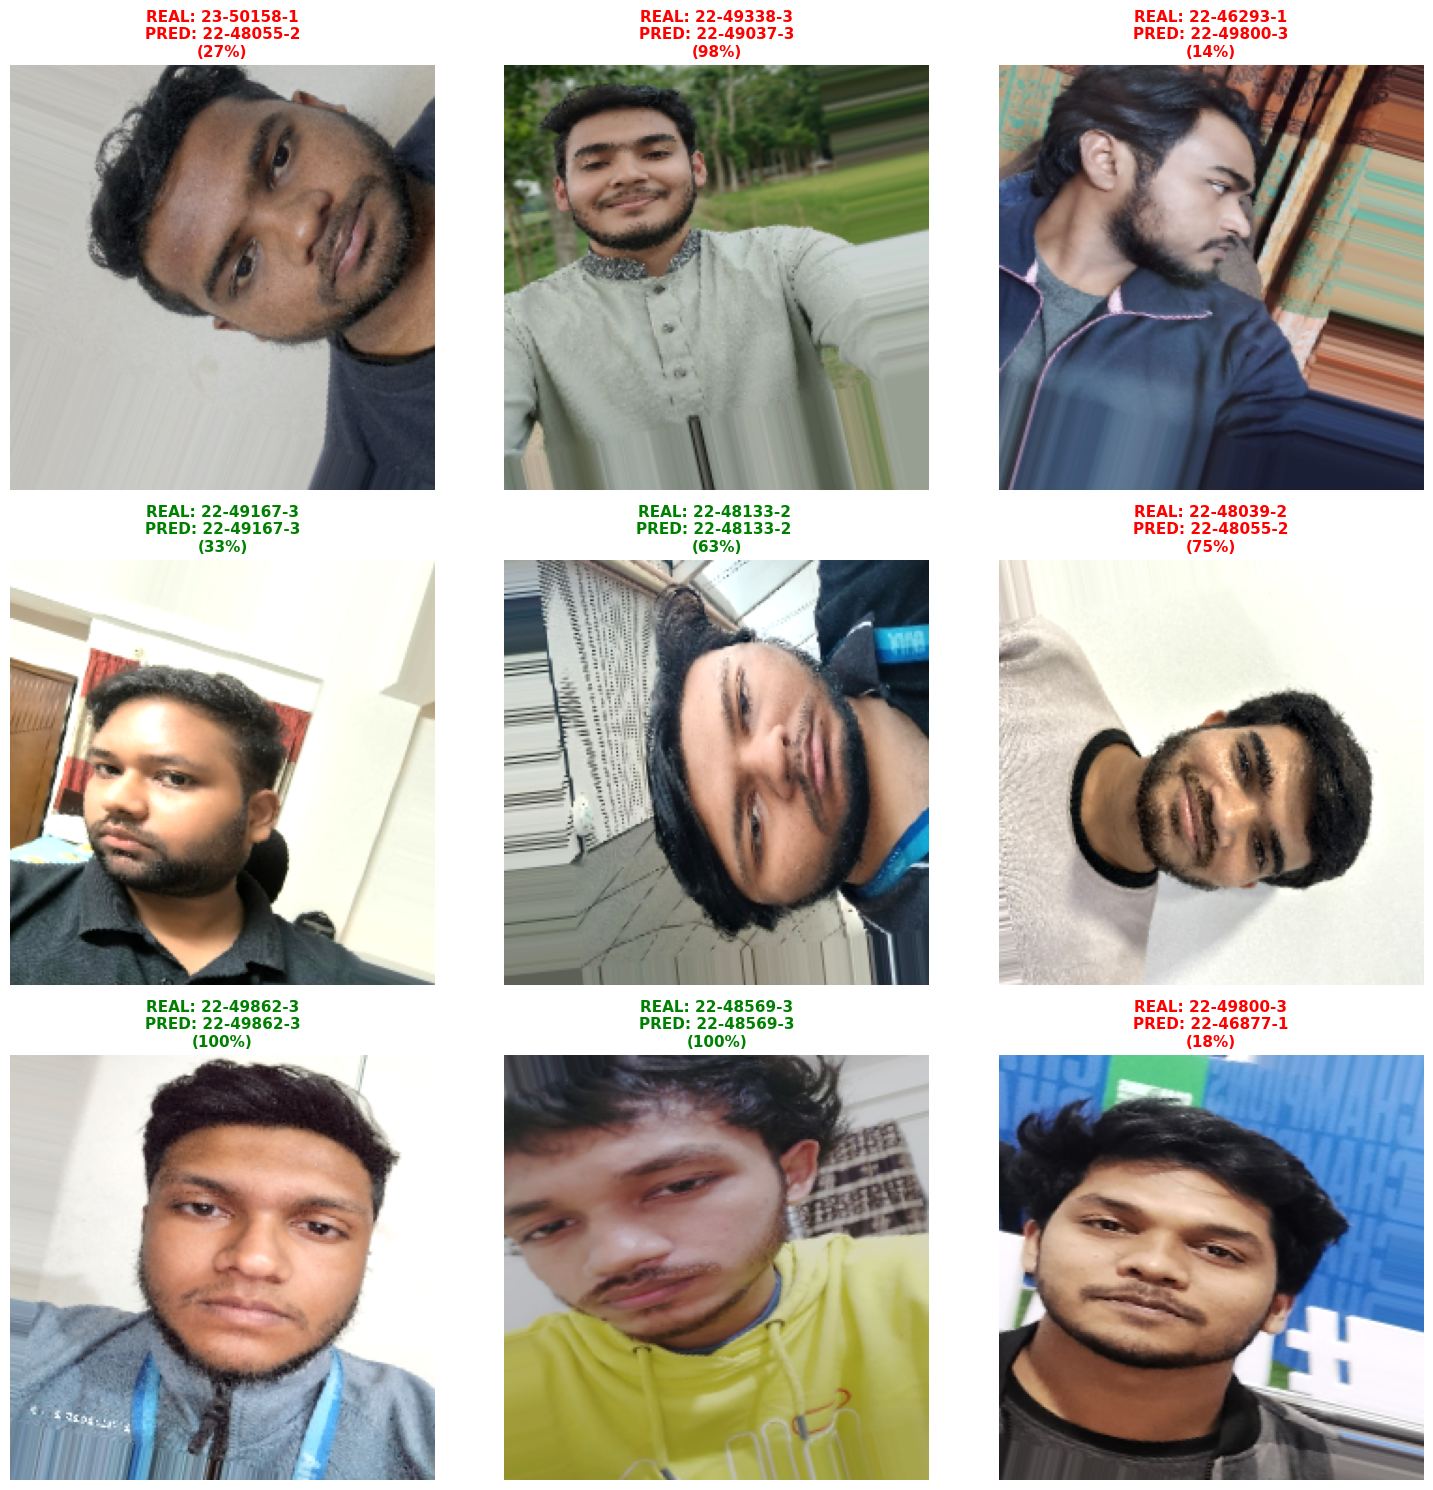

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

test_images, test_labels = next(validation_generator)


print("Asking model to identify students...")
predictions = model.predict(test_images)

# 3. Plot the results in a grid
plt.figure(figsize=(15, 15))


num_to_show = min(9, len(test_images))

for i in range(num_to_show):
    plt.subplot(3, 3, i + 1)

    # Display the image
    plt.imshow(test_images[i])

    
    true_index = np.argmax(test_labels[i])
    pred_index = np.argmax(predictions[i])

   
    true_id = class_names[true_index]
    pred_id = class_names[pred_index]

    
    confidence = np.max(predictions[i])


    color = 'green' if true_index == pred_index else 'red'


    title_text = f"REAL: {true_id}\nPRED: {pred_id}\n({confidence:.0%})"

    plt.title(title_text, color=color, fontsize=11, fontweight='bold')
    plt.axis('off')

plt.tight_layout()
plt.show()